C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Accumulating RRCS sums: 100%|██████████| 15840/15840 [00:00<00:00, 20229.96it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


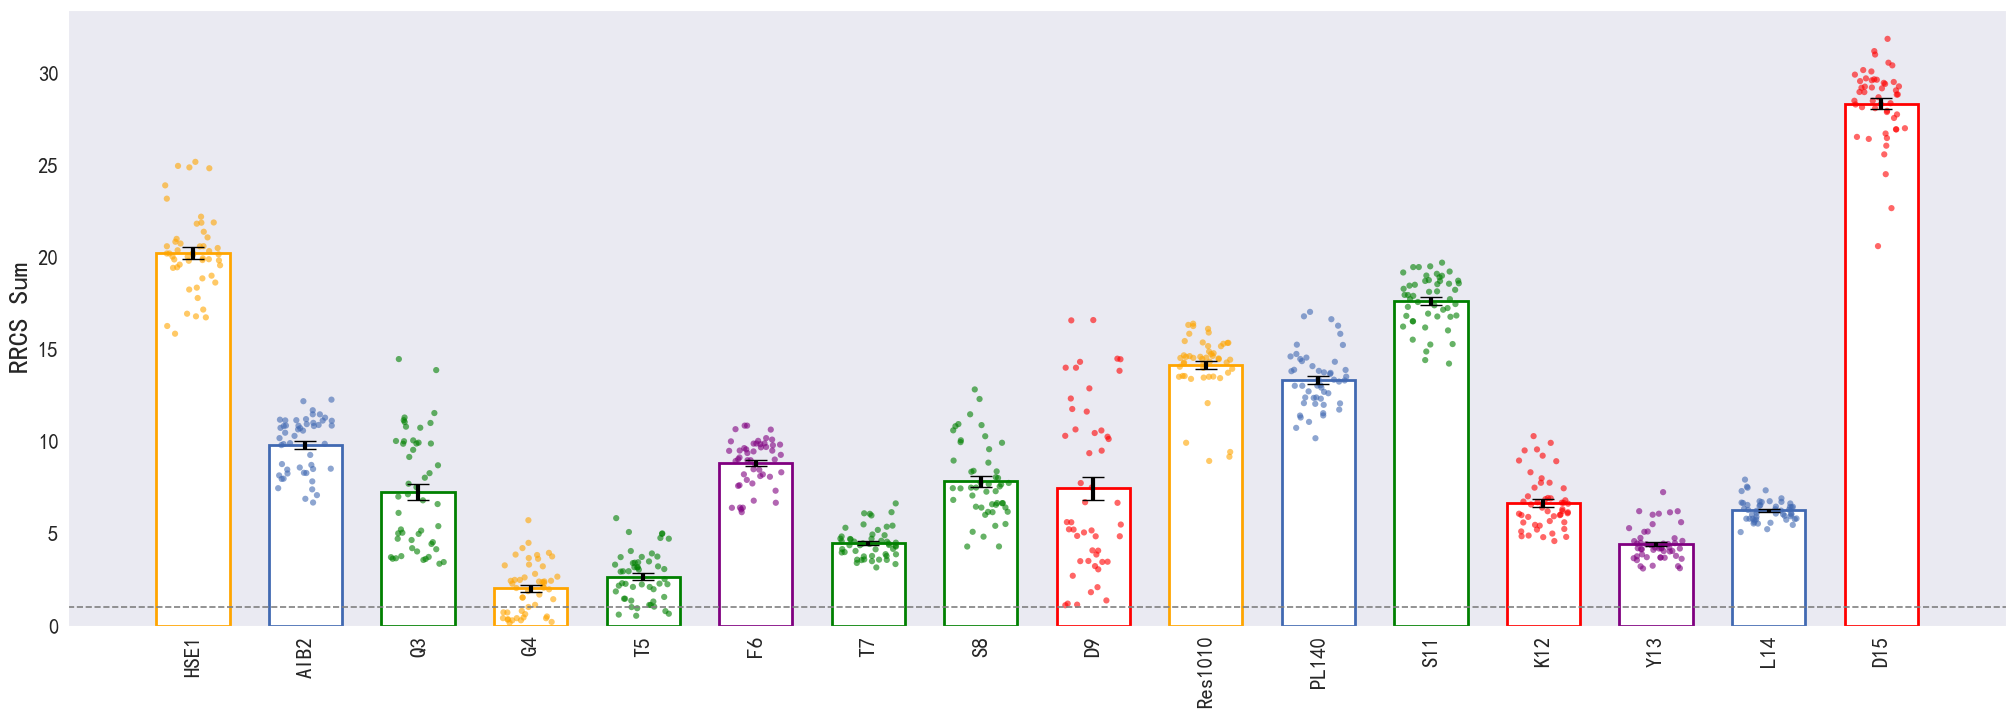

Accumulating RRCS sums by property: 100%|██████████| 15840/15840 [00:00<00:00, 37785.79it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


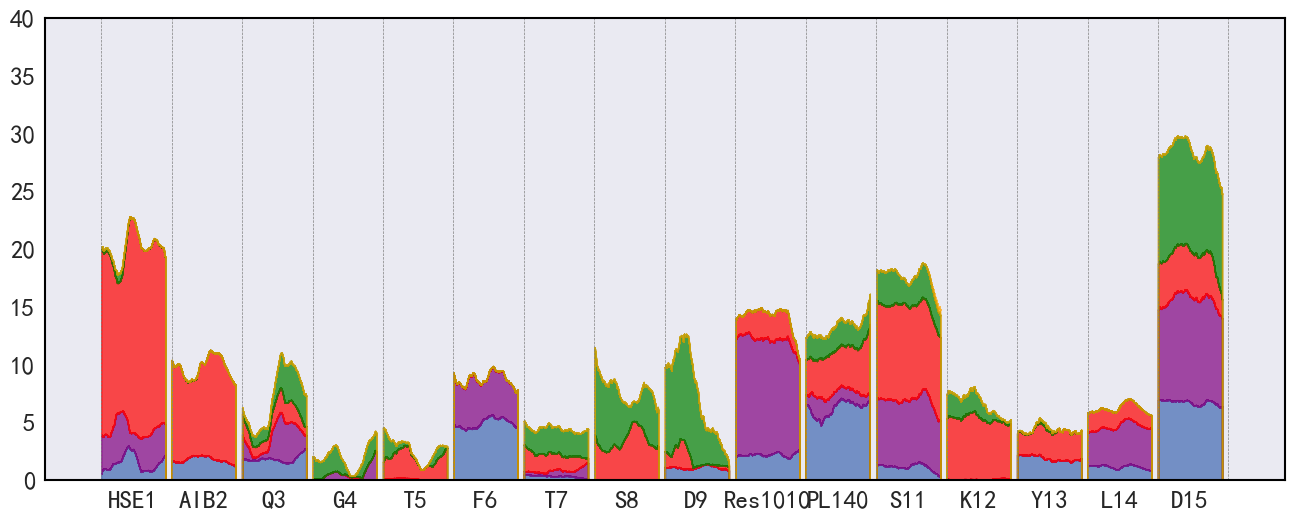

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import MDAnalysis as mda
import pandas as pd

h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  
    residue_pairs_B = hf['residue_pairs_B'][:]  
    times = hf['times'][:]                    
    rrcs = hf['rrcs'][:]   

u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")

resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}

# =======================
# Define amino acid properties and color mapping
# =======================
amino_acid_properties = {
    'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Hydrophobic(Aromatic)', 'TYR': 'Hydrophobic(Aromatic)', 'TRP': 'Hydrophobic(Aromatic)',
    'HIS': 'Electrically charged', 'LYS': 'Electrically charged', 'ARG': 'Electrically charged',
    'ASP': 'Electrically charged', 'GLU': 'Electrically charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special',
    'PL1': 'Hydrophobic', 'AIB': 'Hydrophobic'
}

property_colors = {
    'Hydrophobic': '#4169B2',               # Royal Blue
    'Hydrophobic(Aromatic)': '#800080',     # Purple
    'Electrically charged': '#FF0000',      # Red
    'Polar uncharged': '#008000',           # Green
    'Special': '#FFA500'                     # Orange
}

def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')

# =======================
# Map a residue ID to a property
# =======================
resid_to_property_A = {}
for resid, resname in resid_to_resname_A.items():
    prop = get_amino_acid_property(resname)
    resid_to_property_A[resid] = prop

resid_to_property_B = {}
for resid, resname in resid_to_resname_B.items():
    prop = get_amino_acid_property(resname)
    resid_to_property_B[resid] = prop

# =======================
# Filters the data in the specified time window
# =======================
bt = 500000.0   # 500 ns in ps
et = 1000000.0  # 1000 ns in ps
time_indices = np.where((times >= bt) & (times <= et))[0]
filtered_times = times[time_indices]
filtered_rrcs = rrcs[:, time_indices]

# =======================
# Calculate the total RRCS for each Protein A residue
# =======================
unique_resid_A = np.unique(residue_pairs_A)
rrcs_sum_A_filtered = {resid: np.zeros(len(filtered_times), dtype=np.float32) for resid in unique_resid_A}

for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums"):
    a_resid = residue_pairs_A[i]
    rrcs_sum_A_filtered[a_resid] += filtered_rrcs[i]

# =======================
# Calculate the average RRCS value and standard error for each residue
# =======================
averaged_rrcs_sum_A = {}
averaged_rrcs_values_A = {}
frames_per_average = 100  # Can be adjusted as needed

for resid in unique_resid_A:
    rrcs_sum = rrcs_sum_A_filtered[resid]
    num_complete_averages = len(rrcs_sum) // frames_per_average
    if num_complete_averages == 0:
        print(f"Residue {resid} has less than {frames_per_average} frames.")
        continue
    rrcs_sum_trimmed = rrcs_sum[:num_complete_averages * frames_per_average]
    averaged_rrcs = rrcs_sum_trimmed.reshape(-1, frames_per_average).mean(axis=1)
    averaged_rrcs_sum_A[resid] = averaged_rrcs.mean()
    averaged_rrcs_values_A[resid] = averaged_rrcs

data_for_plot_A = []
for resid in unique_resid_A:
    if resid not in averaged_rrcs_sum_A:
        continue
    mean = averaged_rrcs_sum_A[resid]
    se = np.std(averaged_rrcs_values_A[resid], ddof=1) / np.sqrt(len(averaged_rrcs_values_A[resid]))
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    property_A = get_amino_acid_property(resname)
    label = f"{resid}_{resname}"
    data_for_plot_A.append({'Resid': resid, 'Residue': label, 'Mean': mean, 'SE': se, 'Property': property_A, 'Values': averaged_rrcs_values_A[resid]})

df1_A = pd.DataFrame({
    'Residue': [item['Residue'] for item in data_for_plot_A],
    'Mean': [item['Mean'] for item in data_for_plot_A],
    'SE': [item['SE'] for item in data_for_plot_A],
    'Property': [item['Property'] for item in data_for_plot_A],
    'Resid': [item['Resid'] for item in data_for_plot_A]
})

df2_A = pd.DataFrame({
    'Residue': np.repeat([item['Residue'] for item in data_for_plot_A], len(data_for_plot_A[0]['Values'])),
    'Value': np.concatenate([item['Values'] for item in data_for_plot_A]),
    'Property': np.repeat([item['Property'] for item in data_for_plot_A], len(data_for_plot_A[0]['Values']))
})

# Resid < 15 or Resid == 40
df1_filtered_A_temp = df1_A[(df1_A['Mean'] > 0) & ((df1_A['Resid'] < 16) | (df1_A['Resid'] == 40))].reset_index(drop=True)

desired_resid_order = list(range(1, 16))  # Resid 1 to 14
desired_resid_order.insert(10, 40) 
# Because of the index storage problem of residue PL1
df1_filtered_A = df1_filtered_A_temp[df1_filtered_A_temp['Resid'].isin(desired_resid_order)].reset_index(drop=True)
df1_filtered_A['Resid_Order'] = df1_filtered_A['Resid'].apply(lambda x: desired_resid_order.index(x))
df1_filtered_A = df1_filtered_A.sort_values('Resid_Order').reset_index(drop=True)
filtered_residues_A = df1_filtered_A['Residue'].tolist()
df2_filtered_A = df2_A[df2_A['Residue'].isin(filtered_residues_A)].copy()

aa_dict = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}

def modify_label(label):
    parts = label.split('_')
    if len(parts) == 2:
        resid, resname = parts
        if resname in aa_dict:
            return f"{aa_dict[resname]}{resid}"
        else:
            return f"{resname}{resid}"
    return label

df1_filtered_A['Modified_Residue'] = df1_filtered_A['Residue'].apply(modify_label)
df2_filtered_A['Modified_Residue'] = df2_filtered_A['Residue'].apply(modify_label)
df1_filtered_A['Color'] = df1_filtered_A['Property'].map(property_colors)
df1_filtered_A['Color'] = df1_filtered_A['Color'].fillna('#000000')
df2_filtered_A['Color'] = df2_filtered_A['Property'].map(property_colors)
df2_filtered_A['Color'] = df2_filtered_A['Color'].fillna('#000000')

df1_plot_A = df1_filtered_A.copy()
df2_plot_A = df2_filtered_A.copy()

residues_sorted_A = df1_plot_A['Modified_Residue'].tolist()
x_positions_A = np.arange(len(residues_sorted_A))
residue_to_x_A = {residue: x for x, residue in zip(x_positions_A, residues_sorted_A)}

df2_plot_A['X_num'] = df2_plot_A['Modified_Residue'].map(residue_to_x_A)
df2_clean_A = df2_plot_A.dropna(subset=['X_num'])


jitter_strength = 0.25  

jitter_A = np.random.uniform(-jitter_strength, jitter_strength, size=df2_clean_A.shape[0])

scatter_colors_A = df2_clean_A['Color'].values

plt.figure(figsize=(25, 8), facecolor='white')
bars_A = plt.bar(x_positions_A, df1_plot_A['Mean'], yerr=df1_plot_A['SE'], 
                 color='white', edgecolor=df1_plot_A['Color'], linewidth=2, 
                 width=0.65, label='Mean RRCS', capsize=5, error_kw=dict(lw=3, capsize=8))

plt.scatter(df2_clean_A['X_num'] + jitter_A, df2_clean_A['Value'], 
            color=scatter_colors_A, alpha=0.6, 
            edgecolor='none', s=20, label='Individual RRCS')

plt.axhline(y=1, linestyle='dashed', linewidth=1.2, color='gray')
plt.xlabel("", fontsize=20)
plt.ylabel("RRCS Sum", fontsize=20)

plt.xticks(x_positions_A, df1_plot_A['Modified_Residue'], rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.grid(False)

out_filename_A = "final_figure/Legand_500ns_1000ns_Filtered_bar.eps"
plt.savefig(out_filename_A, format='eps', transparent=False)
plt.show()

properties = list(property_colors.keys())

rrcs_sum_A_properties = {resid: {prop: np.zeros(len(filtered_times), dtype=np.float32) for prop in properties} for resid in df1_filtered_A["Resid"]}

for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums by property"):
    a_resid = residue_pairs_A[i]
    if a_resid not in df1_filtered_A["Resid"].values:
        continue
    b_resid = residue_pairs_B[i]
    property_B = resid_to_property_B.get(b_resid, 'Special') 
    rrcs_value = filtered_rrcs[i]  # Shape: (filtered_frames,)
    rrcs_sum_A_properties[a_resid][property_B] += rrcs_value


num_residues = len(df1_filtered_A["Resid"])
simulation_duration = (et - bt)/1000.0
time_per_residue = simulation_duration
residue_duration = simulation_duration
gap_fraction = 0.1  
gap_duration = gap_fraction * residue_duration
time_per_residue_with_gap = residue_duration + gap_duration
total_time_with_gaps = num_residues * time_per_residue_with_gap

sorted_resid_A = df1_filtered_A.sort_values('Resid_Order')['Resid'].tolist()

smoothed_density_data_per_property = {prop: [] for prop in properties}
x_list = []
concatenated_labels = []
window_size = 1000  

for residue_index, resid in enumerate(sorted_resid_A):
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    label = f"{resid}_{resname}"
    label = modify_label(label)
    concatenated_labels.append(label)
    
    start_time = residue_index * time_per_residue_with_gap
    end_time = start_time + residue_duration

    x_residue = np.linspace(start_time, end_time, len(filtered_times))
    x_list.extend(x_residue)
    
    for prop in properties:
        density_residue = rrcs_sum_A_properties[resid][prop]
        density_residue_series = pd.Series(density_residue)
        smoothed_density_residue = density_residue_series.rolling(window=window_size, min_periods=1, center=True).mean().values
        smoothed_density_data_per_property[prop].extend(smoothed_density_residue)
    
    gap_start = end_time
    gap_end = gap_start + gap_duration
    len_filtered_times_gap = max(1, int(len(filtered_times) * gap_fraction))
    x_gap = np.linspace(gap_start, gap_end, len_filtered_times_gap)
    x_list.extend(x_gap)
    
    for prop in properties:
        density_gap = [0] * len_filtered_times_gap  
        smoothed_density_data_per_property[prop].extend(density_gap)

x = np.array(x_list)
smoothed_density_data = np.array([smoothed_density_data_per_property[prop] for prop in properties])

boundary_times = [residue_index * time_per_residue_with_gap for residue_index in range(num_residues + 1)]
midpoints = [start_time + (residue_duration / 2) for start_time in boundary_times[:-1]]

plt.figure(figsize=(16, 6))
bottom_smoothed = np.zeros_like(x)
for idx, prop in enumerate(properties):
    plt.fill_between(x, bottom_smoothed, bottom_smoothed + smoothed_density_data[idx], 
                     color=property_colors[prop], label=prop, alpha=0.7, step='post')
    bottom_smoothed += smoothed_density_data[idx]

for boundary in boundary_times:
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)
plt.ylim(0,40)  
plt.xticks(midpoints, concatenated_labels, rotation=0,fontsize =18)
plt.yticks(fontsize=18)
# plt.xlabel("", fontsize=20)
# plt.ylabel("RRCS Sum", fontsize=20)
ax = plt.gca()
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

# Optional: Customize the color and width of the axes
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(1.5)
plt.rcParams['axes.facecolor'] = 'white'
# plt.legend(title="Residue B's Properties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
out_filename_A_density = "final_figure2/Legand_500ns_1000ns_Filtered_density.eps"
plt.savefig(out_filename_A_density, format='eps', transparent=False)
plt.show()


Accumulating RRCS sums: 100%|██████████| 15840/15840 [00:01<00:00, 10329.48it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


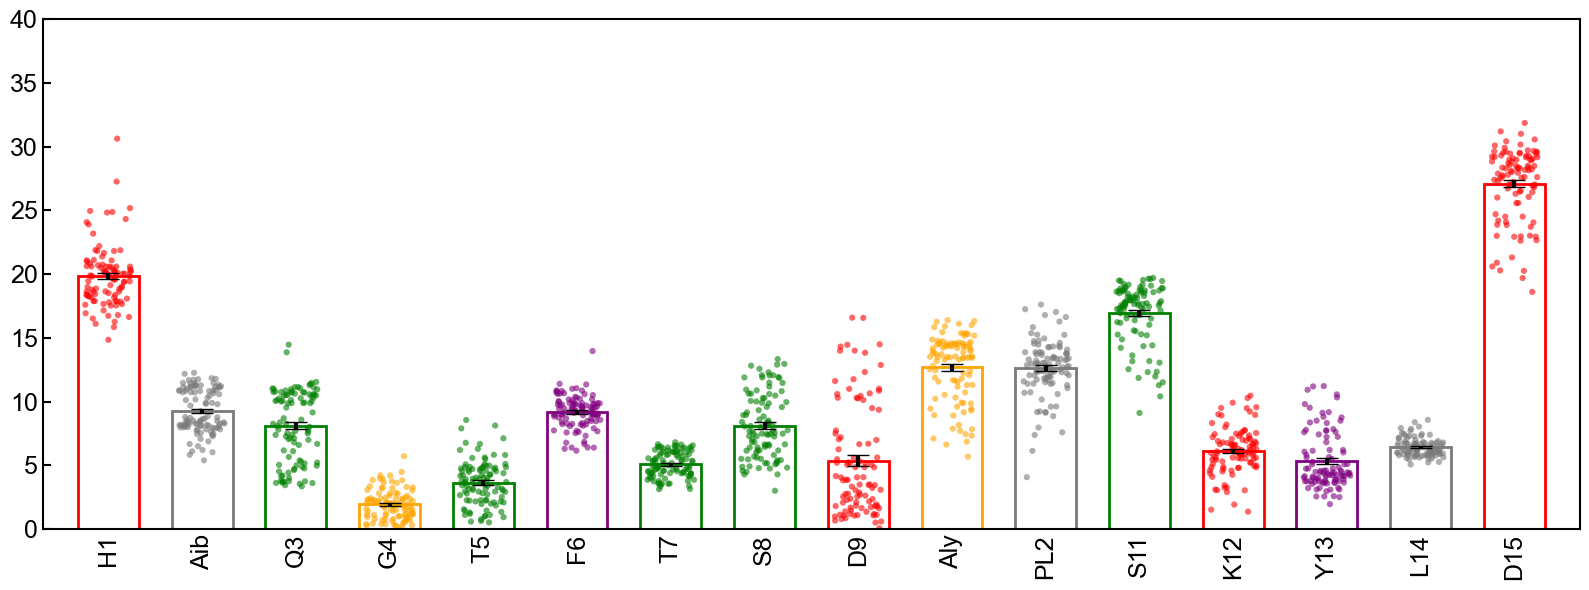

Accumulating RRCS sums by property: 100%|██████████| 15840/15840 [00:00<00:00, 19914.28it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


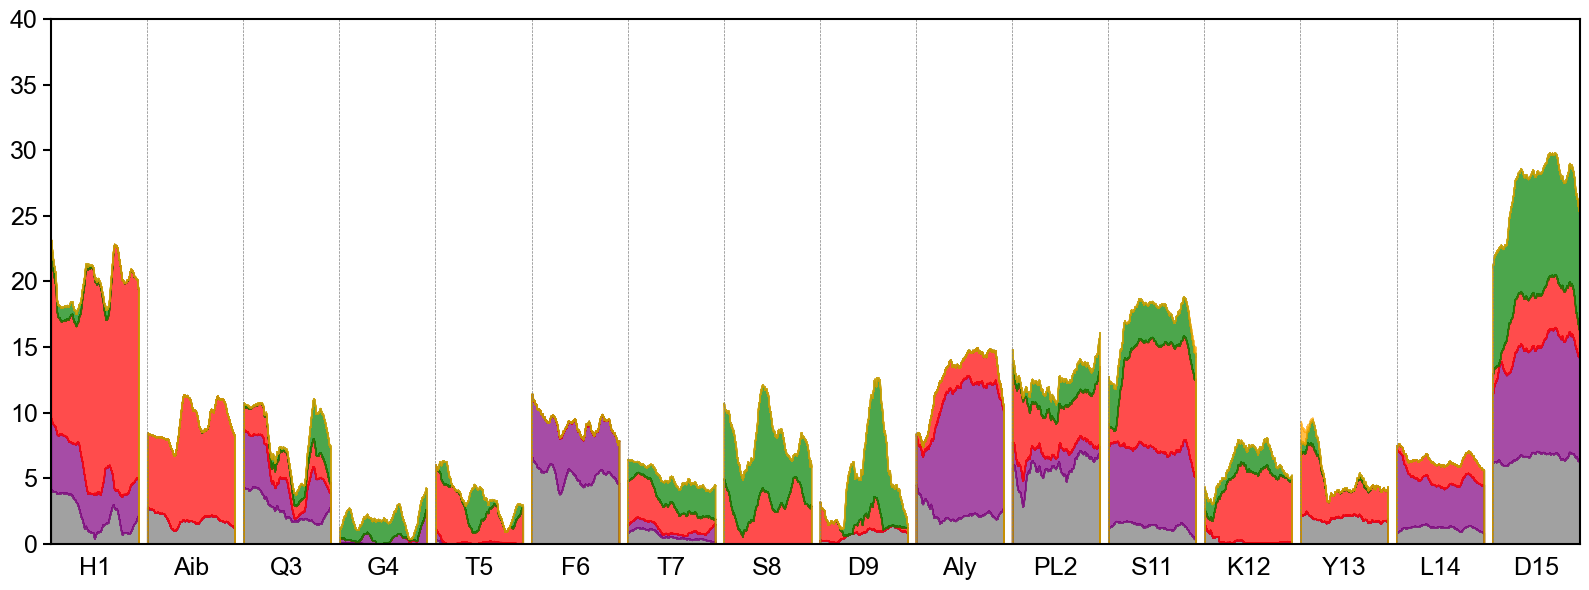

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import MDAnalysis as mda
import pandas as pd

h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  
    residue_pairs_B = hf['residue_pairs_B'][:]  
    times = hf['times'][:]                    
    rrcs = hf['rrcs'][:]   

u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB or resname ALY) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")

resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}

amino_acid_properties = {
    'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Aromatic', 'TYR': 'Aromatic', 'TRP': 'Aromatic',
    'HIS': 'Charged', 'HSE': 'Charged', 'LYS': 'Charged', 'ARG': 'Charged',
    'ASP': 'Charged', 'GLU': 'Charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special',
    'PL1': 'Hydrophobic', 'PL2': 'Hydrophobic', 'AIB': 'Hydrophobic', 'ALY': 'Special'
}

property_colors = {
    'Hydrophobic': '#7A7A7A',          # Gray
    'Aromatic': '#800080',             # Purple
    'Charged': '#FF0000',              # Red
    'Polar uncharged': '#008000',      # Green
    'Special': '#FFA500'               # Orange
}

def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')

resid_to_property_A = {resid: get_amino_acid_property(resname) for resid, resname in resid_to_resname_A.items()}
resid_to_property_B = {resid: get_amino_acid_property(resname) for resid, resname in resid_to_resname_B.items()}


bt = 0.0   # 500 ns in ps
et = 1000000.0  # 1000 ns in ps
time_indices = np.where((times >= bt) & (times <= et))[0]
filtered_times = times[time_indices]
filtered_rrcs = rrcs[:, time_indices]

unique_resid_A = np.unique(residue_pairs_A)
rrcs_sum_A_filtered = {resid: np.zeros(len(filtered_times), dtype=np.float32) for resid in unique_resid_A}

for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums"):
    a_resid = residue_pairs_A[i]
    rrcs_sum_A_filtered[a_resid] += filtered_rrcs[i]

averaged_rrcs_sum_A = {}
averaged_rrcs_values_A = {}
frames_per_average = 100  

for resid in unique_resid_A:
    rrcs_sum = rrcs_sum_A_filtered[resid]
    num_complete_averages = len(rrcs_sum) // frames_per_average
    if num_complete_averages == 0:
        print(f"Residue {resid} has less than {frames_per_average} frames.")
        continue
    rrcs_sum_trimmed = rrcs_sum[:num_complete_averages * frames_per_average]
    averaged_rrcs = rrcs_sum_trimmed.reshape(-1, frames_per_average).mean(axis=1)
    averaged_rrcs_sum_A[resid] = averaged_rrcs.mean()
    averaged_rrcs_values_A[resid] = averaged_rrcs

data_for_plot_A = []
for resid in unique_resid_A:
    if resid not in averaged_rrcs_sum_A:
        continue
    mean = averaged_rrcs_sum_A[resid]
    se = np.std(averaged_rrcs_values_A[resid], ddof=1) / np.sqrt(len(averaged_rrcs_values_A[resid]))
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    property_A = get_amino_acid_property(resname)
    label = f"{resid}_{resname}"
    data_for_plot_A.append({'Resid': resid, 'Residue': label, 'Mean': mean, 'SE': se, 'Property': property_A, 'Values': averaged_rrcs_values_A[resid]})

df1_A = pd.DataFrame({
    'Residue': [item['Residue'] for item in data_for_plot_A],
    'Mean': [item['Mean'] for item in data_for_plot_A],
    'SE': [item['SE'] for item in data_for_plot_A],
    'Property': [item['Property'] for item in data_for_plot_A],
    'Resid': [item['Resid'] for item in data_for_plot_A]
})

df2_A = pd.DataFrame({
    'Residue': np.repeat([item['Residue'] for item in data_for_plot_A], len(data_for_plot_A[0]['Values'])),
    'Value': np.concatenate([item['Values'] for item in data_for_plot_A]),
    'Property': np.repeat([item['Property'] for item in data_for_plot_A], len(data_for_plot_A[0]['Values']))
})

df1_filtered_A_temp = df1_A[(df1_A['Mean'] > 0) & ((df1_A['Resid'] < 16) | (df1_A['Resid'] == 40))].reset_index(drop=True)
desired_resid_order = list(range(1, 16))  # Resid 1 to 15
desired_resid_order.insert(10, 40) 
df1_filtered_A = df1_filtered_A_temp[df1_filtered_A_temp['Resid'].isin(desired_resid_order)].reset_index(drop=True)
df1_filtered_A['Resid_Order'] = df1_filtered_A['Resid'].apply(lambda x: desired_resid_order.index(x))

df1_filtered_A = df1_filtered_A.sort_values('Resid_Order').reset_index(drop=True)

filtered_residues_A = df1_filtered_A['Residue'].tolist()
df2_filtered_A = df2_A[df2_A['Residue'].isin(filtered_residues_A)].copy()
aa_dict = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'HSE': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y',
    'AIB': 'Aib', 'ALY': 'Aly', 'PL1': 'PL2'
}

def modify_label(label):
    parts = label.split('_')
    if len(parts) == 2:
        resid, resname = parts
        resid = int(resid)
        if resid == 1 and resname == 'HSE':
            return 'H1'
        elif resid == 2 and resname == 'AIB':
            return 'Aib'
        elif resid == 10 and resname == 'ALY':
            return 'Aly'
        elif resname == 'PL1':
            return 'PL2'
        else:
            if resname in aa_dict:
                return f"{aa_dict[resname]}{resid}"
            else:
                return f"{resname}{resid}"
    return label

df1_filtered_A['Modified_Residue'] = df1_filtered_A['Residue'].apply(modify_label)
df2_filtered_A['Modified_Residue'] = df2_filtered_A['Residue'].apply(modify_label)

df1_filtered_A['Color'] = df1_filtered_A['Property'].map(property_colors)
df1_filtered_A['Color'] = df1_filtered_A['Color'].fillna('#000000')
df2_filtered_A['Color'] = df2_filtered_A['Property'].map(property_colors)
df2_filtered_A['Color'] = df2_filtered_A['Color'].fillna('#000000')

df1_plot_A = df1_filtered_A.copy()
df2_plot_A = df2_filtered_A.copy()

residues_sorted_A = df1_plot_A['Modified_Residue'].tolist()
x_positions_A = np.arange(len(residues_sorted_A))
residue_to_x_A = {residue: x for x, residue in zip(x_positions_A, residues_sorted_A)}

df2_plot_A['X_num'] = df2_plot_A['Modified_Residue'].map(residue_to_x_A)
df2_clean_A = df2_plot_A.dropna(subset=['X_num'])
jitter_strength = 0.25  

np.random.seed(114514) 

jitter_A = np.random.uniform(-jitter_strength, jitter_strength, size=df2_clean_A.shape[0])

scatter_colors_A = df2_clean_A['Color'].values

plt.figure(figsize=(16, 6), facecolor='white')
bars_A = plt.bar(x_positions_A, df1_plot_A['Mean'], yerr=df1_plot_A['SE'], 
                 color='white', edgecolor=df1_plot_A['Color'], linewidth=2, 
                 width=0.65, label='Mean RRCS', capsize=5, error_kw=dict(lw=3, capsize=8))

plt.scatter(df2_clean_A['X_num'] + jitter_A, df2_clean_A['Value'], 
            color=scatter_colors_A, alpha=0.6, 
            edgecolor='none', s=20, label='Individual RRCS', marker='o')

plt.ylim(0, 40)
plt.xticks(x_positions_A, df1_plot_A['Modified_Residue'], rotation=90, fontsize=18)
plt.yticks(fontsize=18)

ax = plt.gca()

for spine in ['bottom', 'left', 'top', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.5)

ax.tick_params(axis='both', which='major', direction='in', length=6, width=1.5, colors='black',left=True)

padding = 0.7 
ax.set_xlim(min(x_positions_A) - padding, max(x_positions_A) + padding)

ax.set_facecolor('white')

plt.grid(False)
plt.tight_layout()

out_filename_A = "final_figure2/Legand_0ns_1000ns_Filtered_bar.eps"
plt.savefig(out_filename_A, format='eps', transparent=False)
plt.show()

properties = list(property_colors.keys())

rrcs_sum_A_properties = {resid: {prop: np.zeros(len(filtered_times), dtype=np.float32) for prop in properties} for resid in df1_filtered_A["Resid"]}

for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums by property"):
    a_resid = residue_pairs_A[i]
    if a_resid not in df1_filtered_A["Resid"].values:
        continue
    b_resid = residue_pairs_B[i]
    property_B = resid_to_property_B.get(b_resid, 'Special') 
    rrcs_value = filtered_rrcs[i]  # Shape: (filtered_frames,)
    rrcs_sum_A_properties[a_resid][property_B] += rrcs_value

num_residues = len(df1_filtered_A["Resid"])
simulation_duration = (et - bt)/1000.0
residue_duration = simulation_duration
gap_fraction = 0.1  
gap_duration = gap_fraction * residue_duration
time_per_residue_with_gap = residue_duration + gap_duration
total_time_with_gaps = num_residues * time_per_residue_with_gap

sorted_resid_A = df1_filtered_A.sort_values('Resid_Order')['Resid'].tolist()

smoothed_density_data_per_property = {prop: [] for prop in properties}
x_list = []
concatenated_labels = []
window_size = 1000  

for residue_index, resid in enumerate(sorted_resid_A):
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    label = f"{resid}_{resname}"
    label = modify_label(label)
    concatenated_labels.append(label)
    
    start_time = residue_index * time_per_residue_with_gap
    end_time = start_time + residue_duration
    
    x_residue = np.linspace(start_time, end_time, len(filtered_times))
    x_list.extend(x_residue)
    
    for prop in properties:
        density_residue = rrcs_sum_A_properties[resid][prop]
        density_residue_series = pd.Series(density_residue)
        smoothed_density_residue = density_residue_series.rolling(window=window_size, min_periods=1, center=True).mean().values
        smoothed_density_data_per_property[prop].extend(smoothed_density_residue)
    
    gap_start = end_time
    gap_end = gap_start + gap_duration
    len_filtered_times_gap = max(1, int(len(filtered_times) * gap_fraction))
    x_gap = np.linspace(gap_start, gap_end, len_filtered_times_gap)
    x_list.extend(x_gap)
    
    for prop in properties:
        density_gap = [0] * len_filtered_times_gap  
        smoothed_density_data_per_property[prop].extend(density_gap)

x = np.array(x_list)
smoothed_density_data = np.array([smoothed_density_data_per_property[prop] for prop in properties])
boundary_times = [residue_index * time_per_residue_with_gap for residue_index in range(num_residues)]
boundary_times.append(boundary_times[-1] + residue_duration)
midpoints = [start_time + (residue_duration / 2) for start_time in boundary_times[:-1]]

plt.figure(figsize=(16, 6))
bottom_smoothed = np.zeros_like(x)
for idx, prop in enumerate(properties):
    plt.fill_between(x, bottom_smoothed, bottom_smoothed + smoothed_density_data[idx], 
                     color=property_colors[prop], label=prop, alpha=0.7, step='post')
    bottom_smoothed += smoothed_density_data[idx]

for boundary in boundary_times[:-1]:  
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)

plt.ylim(0, 40)
plt.xticks(midpoints, concatenated_labels, rotation=0, fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(boundary_times[0], boundary_times[-1])
ax = plt.gca()
for spine in ['bottom', 'left', 'right', 'top']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.5)

ax.tick_params(axis='both', which='major', direction='out', length=6, width=1.5, colors='black',left=True)
ax.set_facecolor('white')
plt.grid(False)
plt.tight_layout()
out_filename_A_density = "final_figure2/Legand_0ns_1000ns_Filtered_density.eps"
plt.savefig(out_filename_A_density, format='eps', transparent=False)
plt.show()


Accumulating RRCS sums: 100%|██████████| 15840/15840 [00:01<00:00, 11518.05it/s]


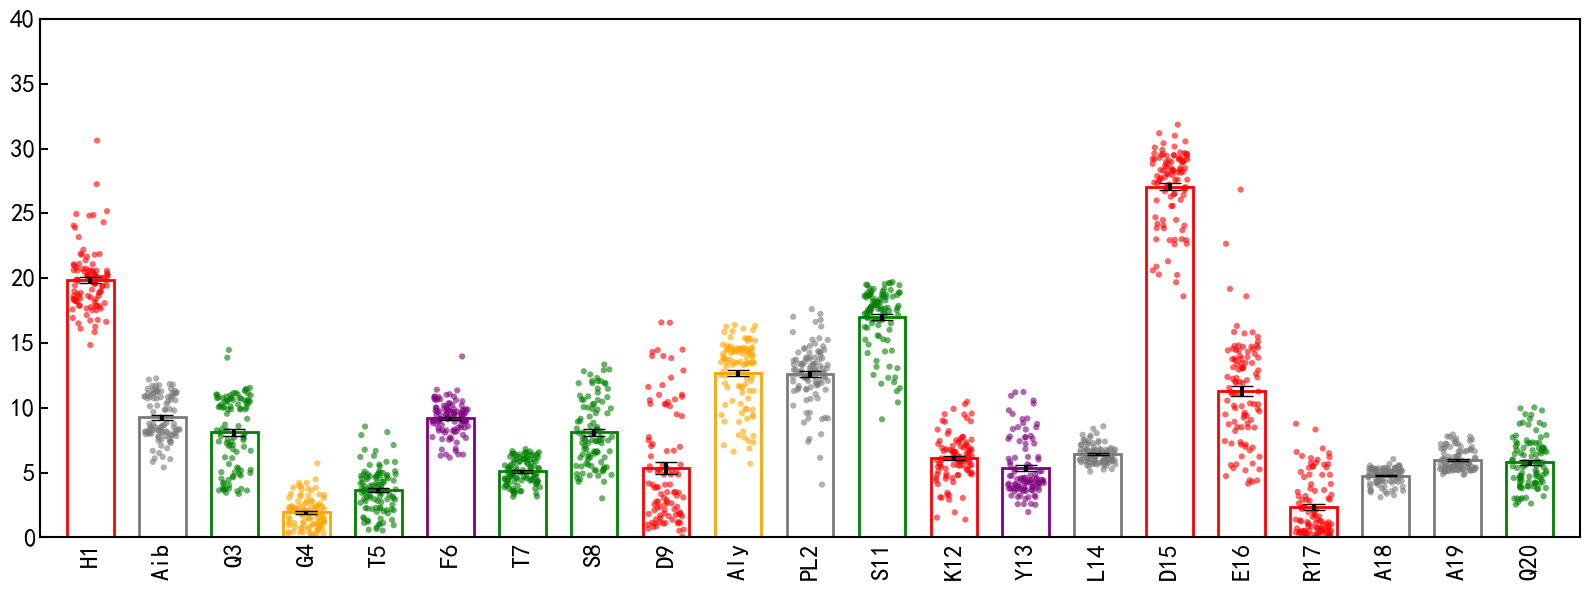

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import MDAnalysis as mda
import pandas as pd
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  
    residue_pairs_B = hf['residue_pairs_B'][:]  
    times = hf['times'][:]                    
    rrcs = hf['rrcs'][:]   

u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB or resname ALY) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")

resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}
amino_acid_properties = {
    'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Aromatic', 'TYR': 'Aromatic', 'TRP': 'Aromatic',
    'HIS': 'Charged', 'HSE': 'Charged', 'LYS': 'Charged', 'ARG': 'Charged',
    'ASP': 'Charged', 'GLU': 'Charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special',
    'PL1': 'Hydrophobic', 'PL2': 'Hydrophobic', 'AIB': 'Hydrophobic', 'ALY': 'Special'
}

property_colors = {
    'Hydrophobic': '#7A7A7A',          # Gray
    'Aromatic': '#800080',             # Purple
    'Charged': '#FF0000',              # Red
    'Polar uncharged': '#008000',      # Green
    'Special': '#FFA500'               # Orange
}

def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')

resid_to_property_A = {resid: get_amino_acid_property(resname) for resid, resname in resid_to_resname_A.items()}
resid_to_property_B = {resid: get_amino_acid_property(resname) for resid, resname in resid_to_resname_B.items()}


bt = 0.0   # 500 ns in ps
et = 1000000.0  # 1000 ns in ps
time_indices = np.where((times >= bt) & (times <= et))[0]
filtered_times = times[time_indices]
filtered_rrcs = rrcs[:, time_indices]


unique_resid_A = np.unique(residue_pairs_A)
rrcs_sum_A_filtered = {resid: np.zeros(len(filtered_times), dtype=np.float32) for resid in unique_resid_A}

for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums"):
    a_resid = residue_pairs_A[i]
    rrcs_sum_A_filtered[a_resid] += filtered_rrcs[i]

averaged_rrcs_sum_A = {}
averaged_rrcs_values_A = {}
frames_per_average = 100  

for resid in unique_resid_A:
    rrcs_sum = rrcs_sum_A_filtered[resid]
    num_complete_averages = len(rrcs_sum) // frames_per_average
    if num_complete_averages == 0:
        print(f"Residue {resid} has less than {frames_per_average} frames.")
        continue
    rrcs_sum_trimmed = rrcs_sum[:num_complete_averages * frames_per_average]
    averaged_rrcs = rrcs_sum_trimmed.reshape(-1, frames_per_average).mean(axis=1)
    averaged_rrcs_sum_A[resid] = averaged_rrcs.mean()
    averaged_rrcs_values_A[resid] = averaged_rrcs
data_for_plot_A = []
for resid in unique_resid_A:
    if resid not in averaged_rrcs_sum_A:
        continue
    mean = averaged_rrcs_sum_A[resid]
    se = np.std(averaged_rrcs_values_A[resid], ddof=1) / np.sqrt(len(averaged_rrcs_values_A[resid]))
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    property_A = get_amino_acid_property(resname)
    label = f"{resid}_{resname}"
    data_for_plot_A.append({'Resid': resid, 'Residue': label, 'Mean': mean, 'SE': se, 'Property': property_A, 'Values': averaged_rrcs_values_A[resid]})

df1_A = pd.DataFrame({
    'Residue': [item['Residue'] for item in data_for_plot_A],
    'Mean': [item['Mean'] for item in data_for_plot_A],
    'SE': [item['SE'] for item in data_for_plot_A],
    'Property': [item['Property'] for item in data_for_plot_A],
    'Resid': [item['Resid'] for item in data_for_plot_A]
})

df2_A = pd.DataFrame({
    'Residue': np.repeat([item['Residue'] for item in data_for_plot_A], len(data_for_plot_A[0]['Values'])),
    'Value': np.concatenate([item['Values'] for item in data_for_plot_A]),
    'Property': np.repeat([item['Property'] for item in data_for_plot_A], len(data_for_plot_A[0]['Values']))
})

df1_filtered_A_temp = df1_A[(df1_A['Mean'] > 0) & ((df1_A['Resid'] < 21) | (df1_A['Resid'] == 40))].reset_index(drop=True)

desired_resid_order = list(range(1, 21)) 
desired_resid_order.insert(10, 40)  
df1_filtered_A = df1_filtered_A_temp[df1_filtered_A_temp['Resid'].isin(desired_resid_order)].reset_index(drop=True)
df1_filtered_A['Resid_Order'] = df1_filtered_A['Resid'].apply(lambda x: desired_resid_order.index(x))
df1_filtered_A = df1_filtered_A.sort_values('Resid_Order').reset_index(drop=True)
filtered_residues_A = df1_filtered_A['Residue'].tolist()
df2_filtered_A = df2_A[df2_A['Residue'].isin(filtered_residues_A)].copy()


aa_dict = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'HSE': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y',
    'AIB': 'Aib', 'ALY': 'Aly', 'PL1': 'PL2'
}

def modify_label(label):
    parts = label.split('_')
    if len(parts) == 2:
        resid, resname = parts
        resid = int(resid)
        if resid == 1 and resname == 'HSE':
            return 'H1'
        elif resid == 2 and resname == 'AIB':
            return 'Aib'
        elif resid == 10 and resname == 'ALY':
            return 'Aly'
        elif resname == 'PL1':
            return 'PL2'
        else:
            if resname in aa_dict:
                return f"{aa_dict[resname]}{resid}"
            else:
                return f"{resname}{resid}"
    return label

df1_filtered_A['Modified_Residue'] = df1_filtered_A['Residue'].apply(modify_label)
df2_filtered_A['Modified_Residue'] = df2_filtered_A['Residue'].apply(modify_label)
df1_filtered_A['Color'] = df1_filtered_A['Property'].map(property_colors)
df1_filtered_A['Color'] = df1_filtered_A['Color'].fillna('#000000')
df2_filtered_A['Color'] = df2_filtered_A['Property'].map(property_colors)
df2_filtered_A['Color'] = df2_filtered_A['Color'].fillna('#000000')
df1_plot_A = df1_filtered_A.copy()
df2_plot_A = df2_filtered_A.copy()

residues_sorted_A = df1_plot_A['Modified_Residue'].tolist()
x_positions_A = np.arange(len(residues_sorted_A))
residue_to_x_A = {residue: x for x, residue in zip(x_positions_A, residues_sorted_A)}

df2_plot_A['X_num'] = df2_plot_A['Modified_Residue'].map(residue_to_x_A)
df2_clean_A = df2_plot_A.dropna(subset=['X_num'])


jitter_strength = 0.25  
np.random.seed(114514)  
jitter_A = np.random.uniform(-jitter_strength, jitter_strength, size=df2_clean_A.shape[0])

scatter_colors_A = df2_clean_A['Color'].values

plt.figure(figsize=(16, 6), facecolor='white')
bars_A = plt.bar(x_positions_A, df1_plot_A['Mean'], yerr=df1_plot_A['SE'], 
                 color='white', edgecolor=df1_plot_A['Color'], linewidth=2, 
                 width=0.65, label='Mean RRCS', capsize=5, error_kw=dict(lw=3, capsize=8))
plt.scatter(df2_clean_A['X_num'] + jitter_A, df2_clean_A['Value'], 
            color=scatter_colors_A, alpha=0.6, 
            edgecolor='none', s=20, label='Individual RRCS', marker='o')
plt.ylim(0, 40)
plt.xticks(x_positions_A, df1_plot_A['Modified_Residue'], rotation=90, fontsize=18)
plt.yticks(fontsize=18)


ax = plt.gca()


for spine in ['bottom', 'left', 'top', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.5)


ax.tick_params(axis='both', which='major', direction='in', length=6, width=1.5, colors='black',left=True)


padding = 0.7 
ax.set_xlim(min(x_positions_A) - padding, max(x_positions_A) + padding)

ax.set_facecolor('white')

plt.grid(False)
plt.tight_layout()

out_filename_A = "final_figure2/Legand_0ns_1000ns_Filtered_bar_choose20.jpg"
plt.savefig(out_filename_A, format='jpg', transparent=False)
plt.show()

In [ ]:

rrcs_dir = r'C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\rrcs_data'
mindist_dir = r'C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\data'
output_dir = r'C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\plot'

color_mapping = {
    '142': {'data_color': '#BFBFBF', 'smooth_color': '#000000'},
    '145': {'data_color': '#BFBFBF', 'smooth_color': '#000000'},
    '146': {'data_color': '#BFBFBF', 'smooth_color': '#000000'},
    '149': {'data_color': '#BFBFBF', 'smooth_color': '#000000'},
    '150': {'data_color': '#BFBFBF', 'smooth_color': '#000000'},
    '153': {'data_color': '#BFBFBF', 'smooth_color': '#000000'},
    '154': {'data_color': '#BFBFBF', 'smooth_color': '#000000'},
    '157': {'data_color': '#BFBFBF', 'smooth_color': '#000000'},
    '202': {'data_color': '#BFBFBF', 'smooth_color': '#000000'},
}

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

rrcs_files = [f for f in os.listdir(rrcs_dir) if f.endswith('.xvg')]
mindist_files = [f for f in os.listdir(mindist_dir) if f.endswith('.xvg')]

for rrcs_file in rrcs_files:
    base_name = os.path.splitext(rrcs_file)[0]  
    resid = base_name.split('&')[-1]  

    mindist_file = f'Mindist-sidechains-{resid}-PL1-0512-P20-GLP1R.xvg'


    if mindist_file not in mindist_files:
        print(f'Mindist file for residue {resid} not found. Skipping.')
        continue


    data_color = color_mapping.get(resid, {}).get('data_color', '#BFBFBF')
    smooth_color = color_mapping.get(resid, {}).get('smooth_color', '#000000')


    rrcs_path = os.path.join(rrcs_dir, rrcs_file).replace('\\', '/')
    mindist_path = os.path.join(mindist_dir, mindist_file).replace('\\', '/')


    output_filename = f'PL1-{resid}.plt'
    output_path = os.path.join(output_dir, output_filename)


    plt_content = f"""

set encoding iso_8859_1
set termoption dash


set terminal postscript eps color solid enhanced
set output 'PL1-{resid}.eps'


set multiplot layout 2,1


set xrange [0:1000]
set xtics 0,200,1000
set xlabel font "Arial,20"
set ylabel font "Arial,20"
set xtics font "Arial,20"
set ytics font "Arial,20"
set key font "Arial,14"
set key spacing 1.2
set border linewidth 2


set size ratio 0.3
set ylabel "RRCS"
set yrange [0:15]
set ytics 0,3,15
unset xlabel
set xtics format ""
unset key

plot '{rrcs_path}' using ($1/1000):2 notitle with lines linewidth 3 lc rgb "#FFB6C1",\\
     '{rrcs_path}' using ($1/1000):2 smooth bezier title 'RRCS Smooth' w l lw 4 lt 2 lc rgb "#FF0000" 


set ylabel "Mindist (Å)"
set xlabel "Time (ns)"
set yrange [0:10]
set ytics 0,2,10
set xtics 0,200,1000
set xtics format "%.0f"
set xlabel offset 0,-0.5
unset key

plot '{mindist_path}' using ($1/1000):($2*10) notitle with lines linewidth 3 lc rgb "#BFBFBF",\\
     '{mindist_path}' using ($1/1000):($2*10) smooth bezier title 'Mindist Smooth' w l lw 4 lt 2 lc rgb "#000000" 

unset multiplot
"""


    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(plt_content)

    print(f'Generated plot script: {output_path}')


Generated plot script: C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\plot\PL1-142.plt
Generated plot script: C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\plot\PL1-145.plt
Generated plot script: C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\plot\PL1-146.plt
Generated plot script: C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\plot\PL1-149.plt
Generated plot script: C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\plot\PL1-150.plt
Generated plot script: C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\plot\PL1-153.plt
Generated plot script: C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\plot\PL1-154.plt
Generated plot script: C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\plot\PL1-157.plt
Generated plot script: C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\plot\PL1-202.plt


In [ ]:
import os
import subprocess


rrcs_dir = r'C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\rrcs_data'
mindist_dir = r'C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\data'
output_dir = r'C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\figure'


color_mapping = {
    '142': {'data_color': '#FF7F0E', 'smooth_color': '#D62728'},
    '145': {'data_color': '#C2A1E2', 'smooth_color': '#800080'},
    '146': {'data_color': '#BFBFBF', 'smooth_color': '#000000'},
    '149': {'data_color': '#E377C2', 'smooth_color': '#7F7F7F'},
    '150': {'data_color': '#17BECF', 'smooth_color': '#BCBD22'},
    '153': {'data_color': '#AEC7E8', 'smooth_color': '#FFBB78'},
    '154': {'data_color': '#98DF8A', 'smooth_color': '#C5B0D5'},
    '157': {'data_color': '#FF9896', 'smooth_color': '#C49C94'},
    '202': {'data_color': '#FFB6C1', 'smooth_color': '#FF0000'},
}


if not os.path.exists(output_dir):
    os.makedirs(output_dir)


rrcs_files = [f for f in os.listdir(rrcs_dir) if f.endswith('.xvg')]
mindist_files = [f for f in os.listdir(mindist_dir) if f.endswith('.xvg')]


for rrcs_file in rrcs_files:

    base_name = os.path.splitext(rrcs_file)[0]  
    resid = base_name.split('&')[-1]  


    mindist_file = f'Mindist-sidechains-{resid}-PL1-0512-P20-GLP1R.xvg'


    if mindist_file not in mindist_files:
        print(f'Mindist file for residue {resid} not found. Skipping.')
        continue


    data_color = color_mapping.get(resid, {}).get('data_color', '#BFBFBF')
    smooth_color = color_mapping.get(resid, {}).get('smooth_color', '#000000')


    rrcs_path = os.path.join(rrcs_dir, rrcs_file).replace('\\', '/')
    mindist_path = os.path.join(mindist_dir, mindist_file).replace('\\', '/')


    output_filename_base = f'PL1-{resid}'
    output_png = os.path.join(output_dir, f'{output_filename_base}.png').replace('\\', '/')
    output_eps = os.path.join(output_dir, f'{output_filename_base}.eps').replace('\\', '/')


    plt_content = f"""
set encoding iso_8859_1
set termoption dash


set terminal postscript eps color solid enhanced
set output '{output_eps}'

set multiplot layout 2,1


set xrange [0:1000]
set xtics 0,200,1000
set xlabel font "Arial,20"
set ylabel font "Arial,20"
set xtics font "Arial,20"
set ytics font "Arial,20"
set key font "Arial,14"
set key spacing 1.2
set border linewidth 2

set size ratio 0.3
set ylabel "RRCS"
set yrange [0:15]
set ytics 0,3,15
unset xlabel
set xtics format ""
unset key

plot '{rrcs_path}' using ($1/1000):2 notitle with lines linewidth 3 lc rgb '{data_color}',\\
     '{rrcs_path}' using ($1/1000):2 smooth bezier notitle w l lw 4 lt 2 lc rgb '{smooth_color}'

set ylabel "Mindist ({{/Symbol \\305}})"
set xlabel "Time (ns)"
set yrange [0:10]
set ytics 0,2,10
set xtics 0,200,1000
set xtics format "%.0f"
set xlabel offset 0,-0.5
unset key

plot '{mindist_path}' using ($1/1000):($2*10) notitle with lines linewidth 3 lc rgb '{data_color}',\\
     '{mindist_path}' using ($1/1000):($2*10) smooth bezier notitle w l lw 4 lt 2 lc rgb '{smooth_color}'

unset multiplot


set terminal pngcairo size 800,600 enhanced font "Arial,12"
set output '{output_png}'


reset
set encoding iso_8859_1
set termoption dash


set multiplot layout 2,1


set xrange [0:1000]
set xtics 0,200,1000
set xlabel font "Arial,20"
set ylabel font "Arial,20"
set xtics font "Arial,20"
set ytics font "Arial,20"
set key font "Arial,14"
set key spacing 1.2
set border linewidth 2

set size ratio 0.3
set ylabel "RRCS"
set yrange [0:15]
set ytics 0,3,15
unset xlabel
set xtics format ""
unset key

plot '{rrcs_path}' using ($1/1000):2 notitle with lines linewidth 3 lc rgb '{data_color}',\\
     '{rrcs_path}' using ($1/1000):2 smooth bezier notitle w l lw 4 lt 2 lc rgb '{smooth_color}'

set ylabel "Mindist (Å)"
set xlabel "Time (ns)"
set yrange [0:10]
set ytics 0,2,10
set xtics 0,200,1000
set xtics format "%.0f"
set xlabel offset 0,-0.5
unset key

plot '{mindist_path}' using ($1/1000):($2*10) notitle with lines linewidth 3 lc rgb '{data_color}',\\
     '{mindist_path}' using ($1/1000):($2*10) smooth bezier notitle w l lw 4 lt 2 lc rgb '{smooth_color}'

unset multiplot
"""


    plt_temp_file = f'{output_filename_base}.plt'
    with open(plt_temp_file, 'w', encoding='utf-8') as f:
        f.write(plt_content)

    try:
        subprocess.run(['gnuplot', plt_temp_file], check=True)
        print(f'Generated plots for residue {resid}:')
        print(f'  EPS: {output_eps}')
        print(f'  PNG: {output_png}')
    except subprocess.CalledProcessError as e:
        print(f'Error generating plots for residue {resid}: {e}')
    # os.remove(plt_temp_file)


Generated plots for residue 142:
  EPS: C:/Users/Hanoi/Desktop/Bilis/WGCNA/pythonProject/final_figure2/PL1/figure/PL1-142.eps
  PNG: C:/Users/Hanoi/Desktop/Bilis/WGCNA/pythonProject/final_figure2/PL1/figure/PL1-142.png
Generated plots for residue 145:
  EPS: C:/Users/Hanoi/Desktop/Bilis/WGCNA/pythonProject/final_figure2/PL1/figure/PL1-145.eps
  PNG: C:/Users/Hanoi/Desktop/Bilis/WGCNA/pythonProject/final_figure2/PL1/figure/PL1-145.png
Generated plots for residue 146:
  EPS: C:/Users/Hanoi/Desktop/Bilis/WGCNA/pythonProject/final_figure2/PL1/figure/PL1-146.eps
  PNG: C:/Users/Hanoi/Desktop/Bilis/WGCNA/pythonProject/final_figure2/PL1/figure/PL1-146.png
Generated plots for residue 149:
  EPS: C:/Users/Hanoi/Desktop/Bilis/WGCNA/pythonProject/final_figure2/PL1/figure/PL1-149.eps
  PNG: C:/Users/Hanoi/Desktop/Bilis/WGCNA/pythonProject/final_figure2/PL1/figure/PL1-149.png
Generated plots for residue 150:
  EPS: C:/Users/Hanoi/Desktop/Bilis/WGCNA/pythonProject/final_figure2/PL1/figure/PL1-150.ep

In [ ]:
import os
import numpy as np


rrcs_dir = r'C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\rrcs_data'
mindist_dir = r'C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\data'


rrcs_files = [f for f in os.listdir(rrcs_dir) if f.endswith('.xvg')]
mindist_files = [f for f in os.listdir(mindist_dir) if f.endswith('.xvg')]


results = {"RRCS": {}, "Mindist": {}}


print("Calculating averages for RRCS files...")
for rrcs_file in rrcs_files:
    rrcs_path = os.path.join(rrcs_dir, rrcs_file)
    try:

        data = np.loadtxt(rrcs_path, comments=['#', '@'])
        avg_rrcs = np.mean(data[:, 1])  
        results["RRCS"][rrcs_file] = avg_rrcs
    except Exception as e:
        print(f"Error processing file {rrcs_file}: {e}")


print("\nCalculating averages for Mindist files...")
for mindist_file in mindist_files:
    mindist_path = os.path.join(mindist_dir, mindist_file)
    try:
        data = np.loadtxt(mindist_path, comments=['#', '@'])
        avg_mindist = np.mean(data[:, 1])  
        results["Mindist"][mindist_file] = avg_mindist
    except Exception as e:
        print(f"Error processing file {mindist_file}: {e}")

print("\nAverage values:")
print("RRCS:")
for file, avg in results["RRCS"].items():
    print(f"  {file}: {avg:.3f}")

print("\nMindist:")
for file, avg in results["Mindist"].items():
    print(f"  {file}: {avg:.3f}")

output_file = r'C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\averages.txt'
with open(output_file, 'w') as f:
    f.write("Average values:\n")
    f.write("RRCS:\n")
    for file, avg in results["RRCS"].items():
        f.write(f"  {file}: {avg:.3f}\n")
    f.write("\nMindist:\n")
    for file, avg in results["Mindist"].items():
        f.write(f"  {file}: {avg:.3f}\n")

print(f"\nAverages saved to {output_file}")


Calculating averages for RRCS files...

Calculating averages for Mindist files...

Average values:
RRCS:
  40&142.xvg: 1.504
  40&145.xvg: 1.179
  40&146.xvg: 1.242
  40&149.xvg: 1.142
  40&150.xvg: 1.118
  40&153.xvg: 1.214
  40&154.xvg: 0.898
  40&157.xvg: 0.701
  40&202.xvg: 3.683

Mindist:
  Mindist-sidechains-142-PL1-0512-P20-GLP1R.xvg: 0.384
  Mindist-sidechains-145-PL1-0512-P20-GLP1R.xvg: 0.417
  Mindist-sidechains-146-PL1-0512-P20-GLP1R.xvg: 0.413
  Mindist-sidechains-149-PL1-0512-P20-GLP1R.xvg: 0.434
  Mindist-sidechains-150-PL1-0512-P20-GLP1R.xvg: 0.441
  Mindist-sidechains-153-PL1-0512-P20-GLP1R.xvg: 0.461
  Mindist-sidechains-154-PL1-0512-P20-GLP1R.xvg: 0.512
  Mindist-sidechains-157-PL1-0512-P20-GLP1R.xvg: 0.539
  Mindist-sidechains-202-PL1-0512-P20-GLP1R.xvg: 0.294

Averages saved to C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\final_figure2\PL1\averages.txt
